# Forecasting Water Levels using LSTMs

In [969]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
import datetime
import os
from math import sqrt
from scipy import stats

In [970]:
df = pd.read_csv('data/Kaub_Level_Since_2013.csv')

In [971]:
path = 'results/' # Used for saving the figures later on

In [972]:
print(df.head())

         date  level
0  2013-01-01    510
1  2013-01-02    461
2  2013-01-03    414
3  2013-01-04    378
4  2013-01-05    351


In [973]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Delete strong outliers with the help of the zscore.

In [974]:
len(df)

3224

In [975]:
df = df[(np.abs(stats.zscore(df)) < 3)]

In [976]:
len(df)

3178

In [977]:
df

,level
0,510
1,461
2,414
3,378
4,351
...,...
3219,117
3220,105
3221,93
3222,85


Split the data in train-validation-test split: 70:20:10 ratio. In order to get a more accurate overall presentation of the data, i.e. to guarantee that the data is i.i.d, one could randomly shuffle the data. This generally leads to lower variance and less overfitting when training a neural network. I did not decide to do this however, since this would influence the performance of the model because the data points are time dependent on each other.

In [978]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [979]:
train_df.describe()

,level
count,2224.000000
mean,201.319694
std,95.047550
min,20.000000
25%,135.000000
50%,191.000000
75%,253.000000
max,513.000000


In [980]:
test_df.describe()

,level
count,318.000000
mean,219.477987
std,96.170185
min,82.000000
25%,141.000000
50%,201.000000
75%,277.000000
max,510.000000


In [981]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

Train mean: 201.3196942446043, Train std: 95.0475499471903


In [982]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

Validation mean: 190.55817610062894, 76.15079163675433


In [983]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

Test mean: 219.47798742138366, 96.17018540710232


As could be seen in the notebook 'analysis', there is a trend in the data. While there exisists an overall downward trend in the water levels of the rhine, as can be seen via linear regression, the overall mean level in the last 10% of the time series actually rose significantly. This is also due to the higher standard deviation, i.e. the water levels have higher highs and lower lows.

Test, if split was successful.

In [984]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

Maybe use moving averages instead of average in the next cell since the model shouldn't have access to future values in the training set when training?!

In [985]:
pre_transformation = train_df

Since there are quite some outliers, we use the RobustScaler instead of the StandardScaler.

In [986]:
scaler = RobustScaler()
scaler.fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [987]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [988]:
train_df

,level
0,2.703390
1,2.288136
2,1.889831
3,1.584746
4,1.355932
...,...
2246,-0.322034
2247,-0.355932
2248,-0.398305
2249,-0.423729


<AxesSubplot:>

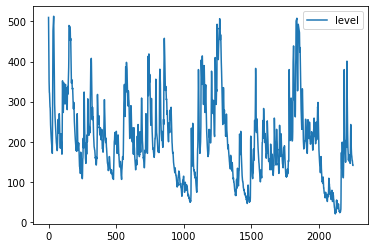

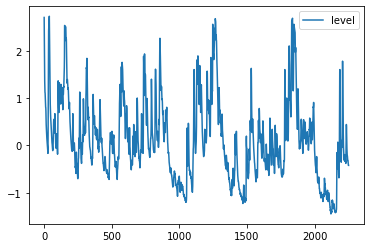

In [989]:
pre_transformation.plot()
train_df.plot()

In [990]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')
      

 The data pre transformation is in range [20,  513]
 the data after transformation is in range: [-0.92, 2.7]


In [991]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [992]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [993]:
def plot(self, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')

WindowGenerator.plot = plot


In [994]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [995]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [996]:
single_step_window = WindowGenerator(
    input_width=30, label_width=30, shift=7,
    label_columns=['level'])
single_step_window

single_step_window


Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['level']

In [997]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    

Inputs shape (batch, time, features): (32, 30, 1)
Labels shape (batch, time, features): (32, 30, 1)


In [998]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [999]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


19/19 [==============================] - 0s 671us/step - loss: 0.2785 - mean_absolute_error: 0.3891


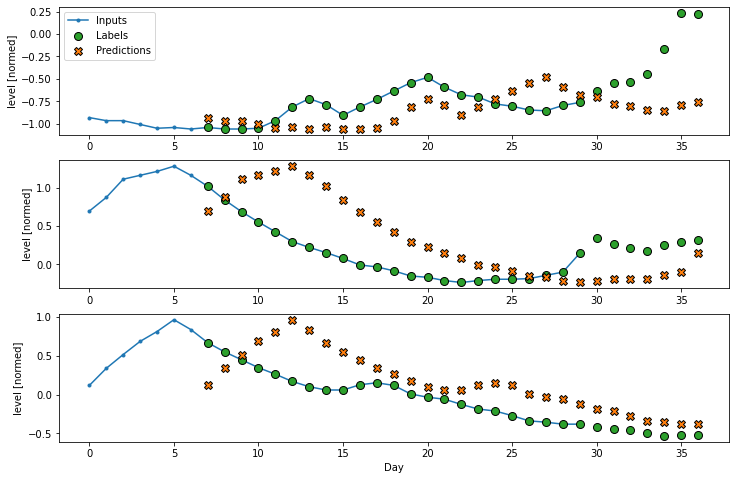

In [1000]:
single_step_window.plot(baseline)


In [1001]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [1002]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(6, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])


In [1003]:
history = compile_and_fit(lstm_model, single_step_window)
train_performance = {}
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 4ms/step - loss: 0.1204 - mean_absolute_error: 0.3956


In [1004]:
lstm_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30, 6)             192       
                                                                 
 lstm_35 (LSTM)              (None, 30, 4)             176       
                                                                 
 dense_29 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


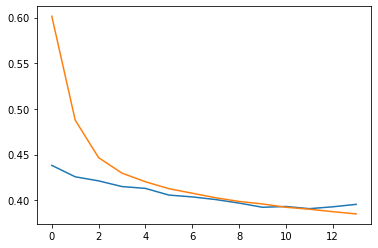

In [1005]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

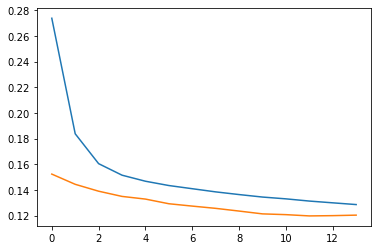

In [1006]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

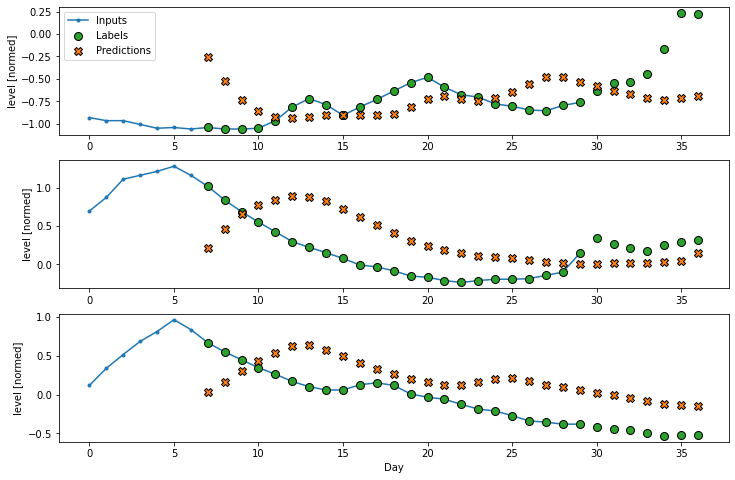

In [1007]:
single_step_window.plot(lstm_model)

In [1008]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name:12s}: {value[1]:0.4f}')


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4200


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

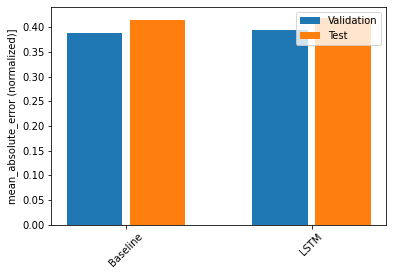

In [1009]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


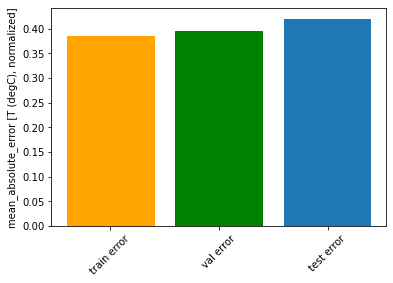

In [1010]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')

plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
predictions = model(inputs)
plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

In [1011]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


In [1012]:
ffn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(6),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(units=1)
])


In [1013]:
history = compile_and_fit(ffn_model, single_step_window)
train_performance = {}
IPython.display.clear_output()
train_performance['Dense'] = ffn_model.evaluate(single_step_window.train)
val_performance['Dense'] = ffn_model.evaluate(single_step_window.val)
performance['Dense'] = ffn_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 803us/step - loss: 0.1086 - mean_absolute_error: 0.3632


In [1014]:
ffn_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 30, 6)             12        
                                                                 
 dense_31 (Dense)            (None, 30, 4)             28        
                                                                 
 dense_32 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [1015]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


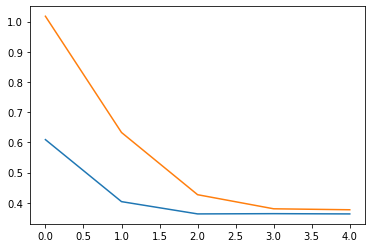

In [1016]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

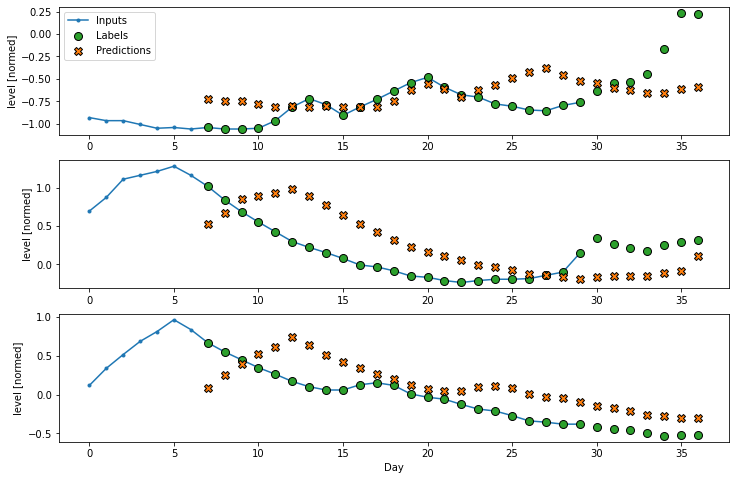

In [1017]:
single_step_window.plot(ffn_model)

In [1018]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name:12s}: {value[1]:0.4f}')


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4200
Test Mean absolute Error Dense       : 0.3820


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

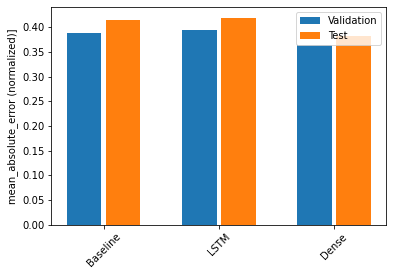

In [1019]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


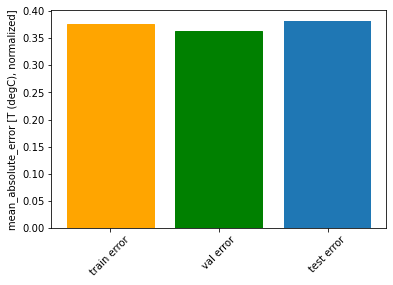

In [1020]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
dense_performance = [train_performance['Dense'][1], val_performance['Dense'][1], performance['Dense'][1]]
barlist = plt.bar(x, dense_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')